# Import

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import mlflow
import mlflow.tensorflow
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)
import re

In [4]:
# import gensim
# gensim.__version__

In [5]:
print(f"Python version: {sys.version}")
print(f"MLflow version: {mlflow.__version__}")

Python version: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:56:31) [Clang 19.1.7 ]
MLflow version: 3.6.0


In [6]:
print("TF:", tf.__version__)
print("GPU physiques:", tf.config.list_physical_devices("GPU"))
print("GPU logiques:", tf.config.list_logical_devices("GPU"))

TF: 2.16.1
GPU physiques: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU logiques: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2025-11-20 20:38:33.012630: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-20 20:38:33.012650: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-20 20:38:33.012656: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-20 20:38:33.013045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-20 20:38:33.013075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
df_train = pd.read_csv("dataset/train_50K.csv")
df_val = pd.read_csv("dataset/val_50K.csv")
df_test = pd.read_csv("dataset/test_50K.csv")
df_train.shape, df_val.shape, df_test.shape

((32000, 6), (8000, 6), (10000, 6))

In [8]:
# df_train = df_train.sample(frac=0.5, random_state=42)
# df_test = df_test.sample(frac=0.5, random_state=42)
# df_val = df_val.sample(frac=0.5, random_state=42)
# df_train.shape, df_val.shape, df_test.shape

In [9]:
# df_train.to_csv("train_50K.csv", index=False)
# df_val.to_csv("val_50K.csv", index=False)
# df_test.to_csv("test_50K.csv", index=False)

# Simple

In [86]:
def soft_preprocess(text):
    # Minuscules
    text = str(text).lower()
    # Supprimer mentions
    text = re.sub(r"@\w+", "", text)
    # Supprimer uniquenment #
    text = re.sub(r"#(\w+)", r"\1", text)
    # # Supprimer mots d'1 lettre
    # text = re.sub(r"\b[a-z]\b", "", text)
    # Nettoyer espaces multiples
    text = re.sub(r"\s+", " ", text).strip()
    return text


text = "RSSJb @qbjhbq #ok a r    v.   qsdsdqs "
soft_preprocess(text)

'rssjb ok a r v. qsdsdqs'

In [87]:
df_train["text"] = df_train["text"].apply(soft_preprocess)
df_test["text"] = df_test["text"].apply(soft_preprocess)
df_val["text"] = df_val["text"].apply(soft_preprocess)

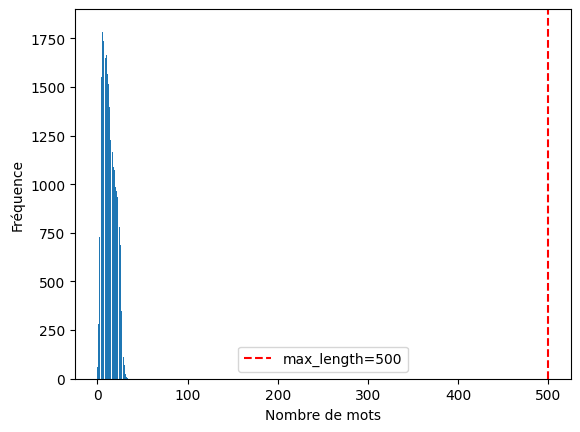

Moyenne: 13 mots
Médiane: 12 mots
Max: 40 mots


In [88]:
lengths = [len(text.split()) for text in df_train["text"]]
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.axvline(x=500, color="r", linestyle="--", label="max_length=500")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

print(f"Moyenne: {np.mean(lengths):.0f} mots")
print(f"Médiane: {np.median(lengths):.0f} mots")
print(f"Max: {np.max(lengths)} mots")

In [89]:
# # Voir tous les optimiseurs disponibles
# from tensorflow.keras import optimizers
# import inspect

# print("Optimiseurs disponibles:")
# for name in dir(optimizers):
#     obj = getattr(optimizers, name)
#     if inspect.isclass(obj) and issubclass(obj, optimizers.Optimizer):
#         print(f"  - {name}")

In [13]:
VOCAB_SIZE = None
MAX_TWEET_LENGTH = 50
BATCH_SIZE = 128
EPOCHS = 20
EMBEDDING_DIM = 32

In [91]:
# Configuration MLflow
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [92]:
# # Load
# df_train = pd.read_csv("train_100K.csv")
# df_val = pd.read_csv("val_100K.csv")
# df_test = pd.read_csv("test_100K.csv")
# df_train.shape, df_val.shape, df_test.shape

In [93]:
# Vectorizer
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_TWEET_LENGTH,  # padding
    # standardize=None,
    # split="whitespace",
)

In [94]:
text_vectorizer.adapt(df_train["text"].values)
vocab_size = len(text_vectorizer.get_vocabulary())
VOCAB_SIZE = vocab_size
print(f" Vocabulaire: {vocab_size} mots")

 Vocabulaire: 33655 mots


In [95]:
# Créer pipeline tensorflow pour optimser le temps d'execution
def make_dataset(df, shuffle=True):
    texts = df["text"].values
    labels = df["target"].values

    dataset = tf.data.Dataset.from_tensor_slices(
        (texts, labels)
    )  # Créer dataset tensorflow => data en paire (texts, labels) => optimisé le traitement
    if shuffle:  # data mélangé, ordre aléatoire => Meilleur generalisation
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(
        tf.data.AUTOTUNE
    )  # prefetch GPU calcule batch 1 // CPU prépare batch2 => gain de temps d'execution, AUTOTUNE=>s'adapte à GPU M2
    return dataset

In [96]:
data_train = make_dataset(df_train, shuffle=True)
data_val = make_dataset(df_val, shuffle=False)
data_test = make_dataset(df_test, shuffle=False)

In [ ]:
# Run mlflow
with mlflow.start_run(run_name=f"ML_Simple_softPreProcess_{VOCAB_SIZE}"):

    # Enregistrement du temps de début
    start_time = time.time()

    # Log
    params = {
        "vocab_size": VOCAB_SIZE,  # =>>>>>> Taille du vocab réel
        "max_length": MAX_TWEET_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "embedding_dim": EMBEDDING_DIM,
        "optimizer": "adamW",
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "Embedding_GAP",
        "gpu": "Apple M2",
    }

    mlflow.log_params(params)

    # Modèle
    model = models.Sequential(
        [
            # Couche de vectorisation
            layers.Input(shape=(1,), dtype=tf.string),
            text_vectorizer,
            layers.Embedding(
                input_dim=VOCAB_SIZE,  # Taille du vocab
                output_dim=32,  # Dimensions des embeddings 
                # input_length=max_tweet_length => optionnel car gap toujours (batch, 32), obligatoire avec flatten
            ),
            # GAP
            layers.GlobalAveragePooling1D(),  # calcul la moyenne des dimensions
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="ml_simple",
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer=AdamW(
            learning_rate=0.001
        ),  # => meilleure régulation (Régularisation L2 intégrée)
        metrics=["accuracy"],
    )

    print(model.summary())

    # Callbacks
    callbacks = [
        # Arrêt précoce si la validation ne s'améliore plus
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,  # Attendre 3 epochs sans amélioration
            restore_best_weights=True,
            verbose=1,
        ),
        # Réduction du learning rate si plateau
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,  # Réduire le LR de moitié
            patience=2,  # Attendre 2 epochs avant de réduire
            verbose=1,
        ),
    ]

    # Train
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    # Calcul du temps d'entraînement total
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Entrainement terminé => {training_time:.2f} secondes")

    # Nombre réel d'époques exécutées
    actual_epochs = len(history.history["loss"])
    print(
        f"\nLogging de {actual_epochs} époques (EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Logger les metriques par épochs
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    # Log des métriques de base dans MLflow
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    print(f"\ntrain_loss: {train_loss}")
    print(f"train_accuracy: {train_accuracy}")
    print(f"\nval_loss: {val_loss}")
    print(f"val_accuracy: {val_accuracy}")
    print(f"\ntest_loss: {test_loss}")
    print(f"test_accuracy: {test_accuracy}")

    # Pred
    # Train
    y_train_pred_proba = model.predict(data_train, verbose=0).flatten()  # Probabilités
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)  # => seuil 0.5
    y_train_true = df_train["target"].values

    # Val
    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    # Test
    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    # Calcul des métriques
    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Métriques train
    mlflow.log_metric("train_accuracy", test_accuracy)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Métriques val
    mlflow.log_metric("val_accuracy", test_accuracy)
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Métriques test
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Overfitting check
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation
    # Train
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)
    # Accuracy
    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    # Sauvegarde et log dans MLflow
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    # Courbe ROC pour train, val,test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Sauvegarder l'image
    plt.savefig("roc_curve_comparaison.png")
    mlflow.log_artifact("roc_curve_comparaison.png")
    plt.close()

    # Créer la signature
    from mlflow.models.signature import infer_signature

    # Input signature
    input_example = df_train["text"].head(3).values
    sample_predictions = model.predict(input_example, verbose=0)

    # Inférer la signature
    signature = infer_signature(input_example, sample_predictions)
    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        registered_model_name=f"ML_Simple_softPreProcess_{VOCAB_SIZE}",
        signature=signature,
        input_example=input_example,
        pip_requirements=[
            f"pandas=={pd.__version__}",
            f"numpy=={np.__version__}",
            f"tensorflow=={tf.__version__}",
        ],
    )

    # Ajout de tags pour faciliter la recherche et l'organisation
    mlflow.set_tags(
        {
            "model_type": "DL_Simple",
            "architecture": "dl_Simple",
            "dataset": "twitter_50K",
        }
    )

Model: "ml_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (Text  (None, 50)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 50, 32)            1076960   
                                                                 
 global_average_pooling1d_9  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_27 (Dense)            (None, 64)                2112      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                20

2025/10/30 20:45:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp1l6ygzgr/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp1l6ygzgr/model/data/model/assets


1/1 [==============================] - 0s 122ms/step


Successfully registered model 'ML_Simple_softPreProcess_33655'.
Created version '1' of model 'ML_Simple_softPreProcess_33655'.


# Word2vec

In [16]:
from gensim.models import Word2Vec

In [17]:
df_train["text"] = df_train["text"].apply(soft_preprocess)
df_test["text"] = df_test["text"].apply(soft_preprocess)
df_val["text"] = df_val["text"].apply(soft_preprocess)

In [43]:
VOCAB_SIZE = None
MAX_TWEET_LENGTH = 50
BATCH_SIZE = 128
EPOCHS = 20
EMBEDDING_DIM = 100
WINDOW = 10
LEARNING_RATE = 0.001

In [ ]:
# Tokenisation simple 
def tokenize(text):
    return text.split()


train_tokens = [tokenize(text) for text in df_train["text"]]

In [46]:
modele_word2vec = Word2Vec(
    sentences=train_tokens,
    vector_size=EMBEDDING_DIM,  #  vector_size 100 dimensions
    window=WINDOW,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    seed=42,
    epochs=EPOCHS,
)
modele_word2vec

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [47]:
print(f"Vocabulaire Word2Vec: {len(modele_word2vec.wv)} mots")

Vocabulaire Word2Vec: 14983 mots


In [ ]:
# Créer matrice d'embedding pré-entraînée

# Créer TextVectorization
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_TWEET_LENGTH,
    standardize=None,  # déjà préprocessé
    split="whitespace",
)

In [49]:
text_vectorizer.adapt(df_train["text"].values)
vocab = text_vectorizer.get_vocabulary()
vocab_size = len(vocab)
VOCAB_SIZE = vocab_size

In [50]:
# Mtrice d'embedding à partir de Word2Vec
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
words_found = 0

for i, word in enumerate(vocab):
    if word in modele_word2vec.wv:
        embedding_matrix[i] = modele_word2vec.wv[word]
        words_found += 1
    # Sinon reste à zéro (mots inconnus)

print(
    f"Mots trouvés dans Word2Vec: {words_found}/{vocab_size} ({100*words_found/vocab_size:.1f}%)"
)

Mots trouvés dans Word2Vec: 14983/50906 (29.4%)


In [51]:
data_train = make_dataset(df_train, shuffle=True)
data_val = make_dataset(df_val, shuffle=False)
data_test = make_dataset(df_test, shuffle=False)
data_train_eval = make_dataset(df_train, shuffle=False)

In [54]:
# Configuration MLflow
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [ ]:
with mlflow.start_run(run_name=f"DL_Simple_Word2Vec_softPreProcess_{VOCAB_SIZE}"):

    # Enregistrement du temps de début
    start_time = time.time()

    # Log des paramètres
    params = {
        "vocab_size": VOCAB_SIZE,
        "max_length": MAX_TWEET_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "embedding_dim": EMBEDDING_DIM,
        "optimizer": "adamW",
        "learning_rate": LEARNING_RATE,
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "Word2Vec_EMB_GAP",
        "gpu": "Apple M2",
        "w2v_window": WINDOW,
        "w2v_min_count": 2,
        "embedding_trainable": True,
        "use_gap": True,
        "dense_1_units": 64,
        "dropout_1": 0.3,
        "dense_2_units": 32,
        "dropout_2": 0.3,
    }

    mlflow.log_params(params)

    # Modèle
    model = models.Sequential(
        [
            layers.Input(shape=(1,), dtype=tf.string),
            text_vectorizer,
            # Embedding avec poids Word2Vec
            layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=EMBEDDING_DIM,
                weights=[embedding_matrix],
                trainable=True,
                mask_zero=False,
            ),
            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="word2vec_model",
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer=AdamW(learning_rate=LEARNING_RATE),
        metrics=["accuracy"],
    )

    print(model.summary())

    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, verbose=1
        ),
    ]

    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )

    print("ok train")

    # Temps d'entraînement
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Temps d'entraînement : {training_time:.2f} secondes")

    # Nombre d'époques réelles
    actual_epochs = len(history.history["loss"])
    mlflow.log_metric("actual_epochs", actual_epochs)
    print(
        f"\nLogging de {actual_epochs} époques "
        f"(EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Log des métriques par époque
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation avec model.evaluate()
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    # Log des métriques de base
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\nMétriques finales :")
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    # Prédictions pour métriques avancées
    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    # Fonction de calcul des métriques avancées
    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    # Calcul des métriques
    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Log des métriques
    # Train
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Validation
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Test
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Métriques d'overfitting
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation - Accuracy et Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    # Accuracy
    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    # Courbe ROC pour train, val, test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - DL Simple Word2Vec Sentiment Analysis")
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("DL_Simple_Word2Vec_roc_curve_comparaison.png")
    mlflow.log_artifact("DL_Simple_Word2Vec_roc_curve_comparaison.png")
    plt.close()

    # Créer la signature
    from mlflow.models.signature import infer_signature

    # Input signature
    input_example = df_train["text"].head(3).values
    sample_predictions = model.predict(input_example, verbose=0)

    # Inférer la signature
    signature = infer_signature(input_example, sample_predictions)

    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        name="model",
        registered_model_name=f"DL_Simple_Word2Vec_{VOCAB_SIZE}",
        signature=signature,
        input_example=input_example,
        pip_requirements=[
            f"pandas=={pd.__version__}",
            f"numpy=={np.__version__}",
            f"tensorflow=={tf.__version__}",
            f"gensim=={gensim.__version__}",
        ],
    )
    print("\nModèle sauvegardé")

    # Tags
    mlflow.set_tags(
        {
            "model_type": "DL_Simple",
            "architecture": "dl_Simple",
            "embedding_type": "Word2Vec_pretrained",
            "embedding_trainable": "True",
            "dataset": "twitter_50K",
        }
    )

Model: "word2vec_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 50)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 50, 100)           5090600   
                                                                 
 global_average_pooling1d_3  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_9 (Dense)             (None, 64)                6464      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)             

INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp5p0ubhw6/model/data/model/assets


1/1 [==============================] - 0s 80ms/step


Registered model 'DL_Simple_Word2Vec_50906' already exists. Creating a new version of this model...
Created version '2' of model 'DL_Simple_Word2Vec_50906'.



Modèle sauvegardé


# GloVe

In [77]:
VOCAB_SIZE = None
MAX_TWEET_LENGTH = 50
BATCH_SIZE = 128
EPOCHS = 20
EMBEDDING_DIM = 100
LEARNING_RATE = 0.001
GLOVE_PATH = "/Users/skanderzahi/Desktop/glove.twitter.27B/glove.twitter.27B.100d.txt"

In [78]:
df_train["text"] = df_train["text"].apply(soft_preprocess)
df_test["text"] = df_test["text"].apply(soft_preprocess)
df_val["text"] = df_val["text"].apply(soft_preprocess)

In [79]:
# Chargement des embeddings
glove_embeddings = {}
embedding_dim_found = None

with open(GLOVE_PATH, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")

        # Vérifier la dimension au premier mot
        if embedding_dim_found is None:
            embedding_dim_found = len(vector)
            print(f"Dimension des embeddings GloVe: {embedding_dim_found}D")

        glove_embeddings[word] = vector

print(f"GloVe chargé: {len(glove_embeddings)} mots")
print(f"Exemples: {list(glove_embeddings.keys())[:92]}")

Dimension des embeddings GloVe: 100D
GloVe chargé: 1193514 mots
Exemples: ['<user>', '.', ':', 'rt', ',', '<repeat>', '<hashtag>', '<number>', '<url>', '!', 'i', 'a', '"', 'the', '?', 'you', 'to', '(', '<allcaps>', '<elong>', ')', 'me', 'de', '<smile>', '！', 'que', 'and', '。', '-', 'my', 'no', '、', 'is', 'it', '…', 'in', 'n', 'for', '/', 'of', 'la', "'s", '*', 'do', "n't", 'that', 'on', 'y', "'", 'e', 'o', 'u', 'en', 'this', 'el', 'so', 'be', "'m", 'with', 'just', '>', 'your', '^', 'like', 'have', 'te', 'at', '？', 'love', 'se', 'are', '<', 'm', 'r', 'if', 'all', 'b', '・', 'not', 'but', 'we', 'es', 'ya', '&', 'follow', 'up', 'what', 'get', 'lol', 'un', '♥', 'lo']


In [80]:
# Vectorisation
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_TWEET_LENGTH,
    standardize=None,  # Déjà préprocessé
    split="whitespace",
)

text_vectorizer.adapt(df_train["text"].values)
vocab = text_vectorizer.get_vocabulary()
vocab_size = len(vocab)
VOCAB_SIZE = vocab_size

print(f"Vocabulaire TensorFlow: {vocab_size} mots")

Vocabulaire TensorFlow: 50905 mots


In [ ]:
# Créer matrice d'embedding depuis GloVe
print("Création de la matrice d'embedding...")
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
words_found = 0
words_not_found = []
# Mapping
for i, word in enumerate(vocab):
    if word in glove_embeddings:
        embedding_matrix[i] = glove_embeddings[word]
        words_found += 1
    else:
        # Mots non trouvés: vecteur aléatoire ou zéro
        # Option 1: Zéro (par défaut)
        # Option 2: Aléatoire
        # embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
        if i > 1:  # Ne pas logger padding et [UNK]
            words_not_found.append(word)

coverage = 100 * words_found / vocab_size
print(f"Couverture GloVe: {words_found}/{vocab_size} mots ({coverage:.1f}%)")
print(f"Mots non trouvés: {len(words_not_found)} (exemples: {words_not_found[:10]})")

Création de la matrice d'embedding...
Couverture GloVe: 19275/50905 mots (37.9%)
Mots non trouvés: 31628 (exemples: ["i'm", "it's", "don't", "can't", '2', "i'll", "didn't", "that's", "you're", "i've"])


In [82]:
data_train = make_dataset(df_train, shuffle=True)
data_val = make_dataset(df_val, shuffle=False)
data_test = make_dataset(df_test, shuffle=False)
data_train_eval = make_dataset(df_train, shuffle=False)

In [83]:
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [85]:
# Run Mlflow
with mlflow.start_run(run_name=f"DL_Simple_GloVe_{VOCAB_SIZE}"):

    start_time = time.time()

    # Paramètres avec info GloVe
    params = {
        "vocab_size": VOCAB_SIZE,
        "max_length": MAX_TWEET_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "embedding_dim": EMBEDDING_DIM,  # 100D
        "optimizer": "AdamW",
        "learning_rate": LEARNING_RATE,
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "GloVe_EMB_GAP",
        "gpu": "Apple M2",
        "glove_source": "glove.twitter.27B.100d",
        "glove_coverage": f"{coverage:.1f}%",
        "embedding_trainable": True,
        "use_gap": True,
        "dense_1_units": 64,
        "dropout_1": 0.3,
        "dense_2_units": 32,
        "dropout_2": 0.3,
    }

    mlflow.log_params(params)

    # Modèle
    model = models.Sequential(
        [
            layers.Input(shape=(1,), dtype=tf.string),
            text_vectorizer,
            # Embedding 100D avec poids GloVe
            layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=EMBEDDING_DIM,  # 100 dimensions
                weights=[embedding_matrix],  # Poids GloVe pré-entraînés
                trainable=True,
                mask_zero=False,  # Ignore padding
                name="glove_embedding",
            ),
            # Architecture identique
            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="glove_model",
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer=AdamW(learning_rate=LEARNING_RATE),
        metrics=["accuracy"],
    )

    print(model.summary())

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, verbose=1
        ),
    ]

    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    # Temps d'entraînement
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Entraînement terminé: {training_time:.2f} secondes")

    # Nombre d'époques réelles
    actual_epochs = len(history.history["loss"])
    print(
        f"\nLogging de {actual_epochs} époques "
        f"(EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Log des métriques par époque
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation avec model.evaluate()
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\ntrain_loss: {train_loss}")
    print(f"train_accuracy: {train_accuracy}")
    print(f"\nval_loss: {val_loss}")
    print(f"val_accuracy: {val_accuracy}")
    print(f"\ntest_loss: {test_loss}")
    print(f"test_accuracy: {test_accuracy}")

    # Prédictions pour métriques avancées
    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    # Fonction de calcul des métriques avancées
    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Log métriques train
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Log métriques val
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Log métriques test
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Métriques d'overfitting
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation - Accuracy et Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    # Accuracy
    ax1.plot(epochs_range, history.history["accuracy"], "b-", label="Train Accuracy")
    ax1.plot(epochs_range, history.history["val_accuracy"], "r:", label="Val Accuracy")
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("glove_training_history.png")
    mlflow.log_artifact("glove_training_history.png")
    plt.close()

    # Courbe ROC
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - GloVe Embeddings")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("glove_roc_curve_comparaison.png")
    mlflow.log_artifact("glove_roc_curve_comparaison.png")
    plt.close()

    # Créer la signature
    from mlflow.models.signature import infer_signature

    # Input signature
    input_example = df_train["text"].head(3).values
    sample_predictions = model.predict(input_example, verbose=0)

    # Inférer la signature
    signature = infer_signature(input_example, sample_predictions)

    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        registered_model_name=f"GloVe_Twitter_100D_{VOCAB_SIZE}",
        signature=signature,
        input_example=input_example,
        pip_requirements=[
            f"pandas=={pd.__version__}",
            f"numpy=={np.__version__}",
            f"tensorflow=={tf.__version__}",
        ],
    )
    print("\nModèle sauvegardé")

    # Tags
    mlflow.set_tags(
        {
            "model_type": "DL_Simple",
            "architecture": "dl_Simple",
            "embedding_type": "GloVe_pretrained",
            "embedding_trainable": "True",
            "embedding_source": "glove.twitter.27B.100d",
            "dataset": "twitter_50K",
        }
    )

Model: "glove_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (Text  (None, 50)                0         
 Vectorization)                                                  
                                                                 
 glove_embedding (Embedding  (None, 50, 100)           5090500   
 )                                                               
                                                                 
 global_average_pooling1d_8  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_24 (Dense)            (None, 64)                6464      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                       

2025/10/30 20:38:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp2etbe3s8/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp2etbe3s8/model/data/model/assets


1/1 [==============================] - 0s 149ms/step

Modèle sauvegardé


Successfully registered model 'GloVe_Twitter_100D_50905'.
Created version '1' of model 'GloVe_Twitter_100D_50905'.


In [ ]:
import re
import time
import mlflow
import mlflow.tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)

# ============================================================================
# CONFIGURATION
# ============================================================================

# USE

In [8]:
import tensorflow_hub as hub

/opt/anaconda3/envs/p7_use_m2/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [9]:
BATCH_SIZE = 32
EPOCHS = 20
USE_DIM = 512

In [10]:
df_train = pd.read_csv("dataset/train_50K.csv")
df_val = pd.read_csv("dataset/val_50K.csv")
df_test = pd.read_csv("dataset/test_50K.csv")

In [11]:
# Preprocess
def soft_preprocess(text):
    text = str(text).lower()
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


df_train["text"] = df_train["text"].apply(soft_preprocess)
df_val["text"] = df_val["text"].apply(soft_preprocess)
df_test["text"] = df_test["text"].apply(soft_preprocess)

In [12]:
# Pipiline tf
def make_dataset(df, shuffle=True):
    texts = df["text"].values
    labels = df["target"].values
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


data_train = make_dataset(df_train, shuffle=True)
data_train_eval = make_dataset(df_train, shuffle=False)
data_val = make_dataset(df_val, shuffle=False)
data_test = make_dataset(df_test, shuffle=False)

In [13]:
# Config MLflow
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

/opt/anaconda3/envs/p7_use_m2/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [14]:
with mlflow.start_run(run_name=f"DL_USE_Dense_softPreProcess"):

    start_time = time.time()

    params = {
        "use_dim": USE_DIM,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": "AdamW",
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "USE_Dense",
        "gpu": "Apple M2",
    }

    mlflow.log_params(params)

    # Construction du modèle

    print("Chargement de Universal Sentence Encoder...")

    # Charger USE
    use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    use_layer = hub.KerasLayer(use_url, trainable=False, name="USE")

    # Wrapper pour USE
    def use_wrapper(text):
        return use_layer(text)

    # Construction du modèle avec Functional API
    text_input = layers.Input(shape=(), dtype=tf.string, name="text_input")

    # USE via Lambda avec output_shape explicite (512 dimensions)
    use_output = layers.Lambda(use_wrapper, output_shape=(512,), name="use_embedding")(
        text_input
    )

    x = layers.Dense(256, activation="relu", name="dense_1")(use_output)
    x = layers.Dropout(0.4, name="dropout_1")(x)

    x = layers.Dense(128, activation="relu", name="dense_2")(x)
    x = layers.Dropout(0.3, name="dropout_2")(x)

    x = layers.Dense(64, activation="relu", name="dense_3")(x)
    x = layers.Dropout(0.2, name="dropout_3")(x)

    output = layers.Dense(1, activation="sigmoid", name="output")(x)

    model = models.Model(inputs=text_input, outputs=output, name="use_dense_model")

    # Compilation
    model.compile(
        loss="binary_crossentropy",
        optimizer=AdamW(learning_rate=0.001),
        metrics=["accuracy"],
    )

    model.summary()

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
        ),
    ]

    # Entraînement
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Entrainement termine => {training_time:.2f} secondes")

    actual_epochs = len(history.history["loss"])
    mlflow.log_metric("actual_epochs", actual_epochs)
    print(
        f"\nLogging de {actual_epochs} epoques (EarlyStopping peut avoir arrete avant {EPOCHS})"
    )

    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    train_loss, train_accuracy = model.evaluate(data_train_eval, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\nTrain - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )
    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )
    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.savefig("roc_curve_comparaison.png")
    mlflow.log_artifact("roc_curve_comparaison.png")
    plt.close()

    # Sauvegarde du modèle

    # MLflow
    mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        registered_model_name=f"DL_USE_Dense_softPreProcess",
    )

    # Sauvegarde format keras
    model_path = "models/dl_use_sentiment.keras"
    model.save(model_path)
    print("Sauvegarder ok")

    mlflow.set_tags(
        {
            "model_type": "ML_avance",
            "architecture": "use_dense",
            "dataset": "twitter_50K",
        }
    )


print("ENTRAINEMENT TERMINE")
print(f"  Test Accuracy : {test_accuracy:.4f}")
print(f"  Test F1-Score : {test_f1:.4f}")
print(f"  Test ROC-AUC  : {test_roc_auc:.4f}")

Chargement de Universal Sentence Encoder...


2025-11-20 19:45:18.194031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Model: "use_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding (Lambda)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,545 (674.00 KB)

 Trainable params: 172,545 (674.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.7604 - loss: 0.4977 - val_accuracy: 0.7688 - val_loss: 0.4757 - learning_rate: 0.0010
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - accuracy: 0.7644 - loss: 0.4955 - val_accuracy: 0.7729 - val_loss: 0.4765 - learning_rate: 0.0010
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - accuracy: 0.7680 - loss: 0.4926 - val_accuracy: 0.7756 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7713 - loss: 0.4923
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 76s 76ms/step - accuracy: 0.7701 - loss: 0.4984 - val_accuracy: 0.7788 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 114s 114ms/step - accuracy: 0.7686 - loss: 0.4907 - val_accuracy: 0.7754 - val_loss: 0.4767 - learning_rate: 5.0000e-04
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 157s 157ms/step - 

2025/11/20 20:23:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:23:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/20 20:24:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmpup3nkzxt/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/11/20 20:24:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/anaconda3/envs/p7_use_m2/lib/python3.11/site-packages/mlflow/tracking/_model_registry/

Sauvegarder ok
ENTRAINEMENT TERMINE
  Test Accuracy : 0.7660
  Test F1-Score : 0.7728
  Test ROC-AUC  : 0.8475


In [10]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")